In [3]:
import sys
sys.executable


sys.path

['C:\\Users\\Joelr\\Keras_EPQ',
 'C:\\Users\\Joelr\\Anaconda3\\python37.zip',
 'C:\\Users\\Joelr\\Anaconda3\\DLLs',
 'C:\\Users\\Joelr\\Anaconda3\\lib',
 'C:\\Users\\Joelr\\Anaconda3',
 '',
 'C:\\Users\\Joelr\\AppData\\Roaming\\Python\\Python37\\site-packages',
 'C:\\Users\\Joelr\\Anaconda3\\lib\\site-packages',
 'C:\\Users\\Joelr\\Anaconda3\\lib\\site-packages\\torchsampler-0.1-py3.7.egg',
 'C:\\Users\\Joelr\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\Joelr\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\Joelr\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\Joelr\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Joelr\\.ipython']

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
#from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers, preprocessing, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
import datetime, os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import numpy as np
import seaborn as sn
import pandas as pd

%load_ext tensorboard

In [2]:
# Important variables
EPOCHS = 50

TRAIN_DIR = "C:/Users\Joelr/Keras_EPQ/x_rays/train"
TEST_DIR = "C:/Users\Joelr/Keras_EPQ/x_rays/test"

BATCH_SIZE = 16

IMG_HEIGHT = 150
IMG_WIDTH = 150

CLASSES = ["0","1","2","3","4"]

In [3]:
# Data preprocessing

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=5,
    width_shift_range=2.0,
    height_shift_range=2.0,
    zoom_range=0.125,
    channel_shift_range=3.0,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255
)

test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = train_gen.flow_from_directory(directory= TRAIN_DIR,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = CLASSES)

test_data_gen = test_gen.flow_from_directory(directory= TEST_DIR,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = CLASSES)



 
    
# Alter class weights to to counter imbalance
weight = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_data_gen.classes), 
                train_data_gen.classes)

CLASS_WEIGHTS = dict(enumerate(weight))

Found 7392 images belonging to 5 classes.
Found 462 images belonging to 5 classes.


c:\users\joelr\anaconda3\envs\gamer\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [4]:
# Define model
base = VGG19(weights='imagenet', include_top=False,input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))


# Take output from pre-trained and put through custom classifier
x = base.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x =tf.keras.layers.Dense(1024, activation='relu')(x)
x =tf.keras.layers.Dense(512, activation='relu')(x)
x =tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x) #OUtput is an array of probabilities 0-1

model = Model(inputs=base.input, outputs=output)

In [5]:
#for i, layer in enumerate(base_model.layers):
    #print(i, layer.name)

#model.summary()
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:11]:
   layer.trainable = False
for layer in model.layers[11:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD, Adam
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['acc'])

In [6]:
#Train

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3,
                              min_lr=0,
                              cooldown=0,
                              min_delta=0.001,
                              verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.1,
    patience=15,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

callbacks = [tensorboard_callback, reduce_lr]

model.fit(x = train_data_gen,
         epochs = EPOCHS,
         validation_data = test_data_gen,
          callbacks=callbacks,
          class_weight = CLASS_WEIGHTS
         )


Epoch 1/50
  1/462 [..............................] - ETA: 0s - loss: 1.8744 - acc: 0.0625WARNING:tensorflow:From c:\users\joelr\anaconda3\envs\gamer\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
462/462 [==============================] - 90s 194ms/step - loss: 1.5794 - acc: 0.1951 - val_loss: 1.4924 - val_acc: 0.3377
Epoch 2/50
462/462 [==============================] - 51s 110ms/step - loss: 1.4485 - acc: 0.2638 - val_loss: 1.3746 - val_acc: 0.3745
Epoch 3/50
462/462 [==============================] - 51s 110ms/step - loss: 1.2661 - acc: 0.3460 - val_loss: 1.3662 - val_acc: 0.3485
Epoch 4/50
462/462 [==============================] - 51s 111ms/step - loss: 1.1063 - acc: 0.4095 - val_loss: 1.0283 - val_acc: 0.5000
Epoch 5/50
462/462 [==============================] - 51s 111ms/step - loss: 1.0046 - ac

In [7]:
model.save('VGG19 Final.h5',include_optimizer=True)

In [5]:
model = load_model("my_model.h5")

In [8]:
preds_array = model.predict(test_data_gen)
preds = np.argmax(preds_array, axis=1)

conf_mat = confusion_matrix(test_data_gen.classes, preds)
print('Confusion Matrix')
print(conf_mat,"\n")
print('Classification Report')
print(classification_report(test_data_gen.classes, preds, target_names=CLASSES))

# Precision = True Positives / True Positives + False Positives i.e. Out of all the knees labelled as 4, how many were actually 4
# Recall = True Pos / True pos + False neg i.e. Out of all the knees that were actually 4, how many were labelled 4

Confusion Matrix
[[73 23  4  0  0]
 [34 48 16  2  0]
 [10 25 53 12  0]
 [ 0  3  4 89  4]
 [ 0  0  0  8 54]] 

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.73      0.67       100
           1       0.48      0.48      0.48       100
           2       0.69      0.53      0.60       100
           3       0.80      0.89      0.84       100
           4       0.93      0.87      0.90        62

    accuracy                           0.69       462
   macro avg       0.71      0.70      0.70       462
weighted avg       0.69      0.69      0.68       462



In [9]:
#Heatmap of confusion matrix

%matplotlib
sn.heatmap(conf_mat, annot=True, 
            fmt='', cmap='Blues')


plt.ylabel('True')
plt.xlabel('Predicted')
b, t = plt.ylim()
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show() 

Using matplotlib backend: TkAgg


C:\Users\Joelr\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


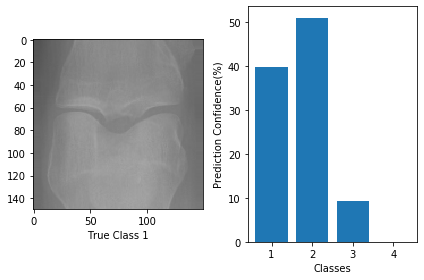

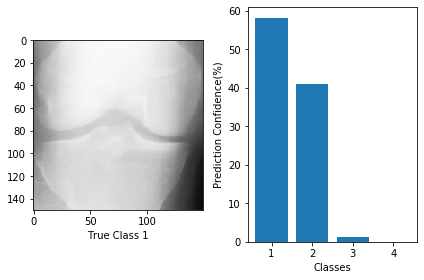

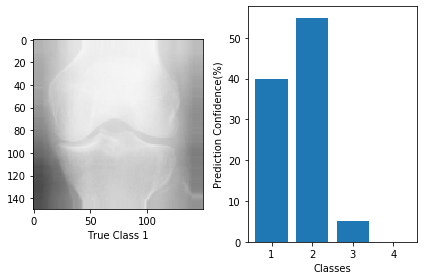

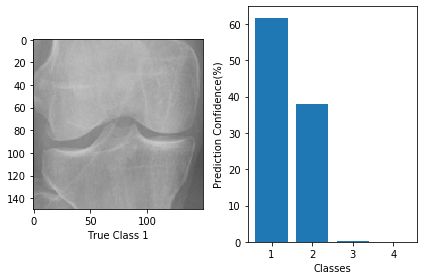

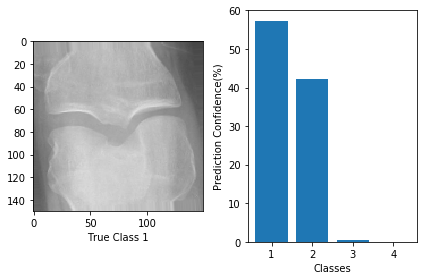

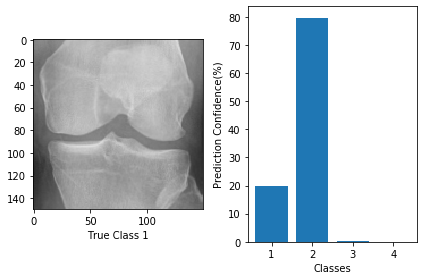

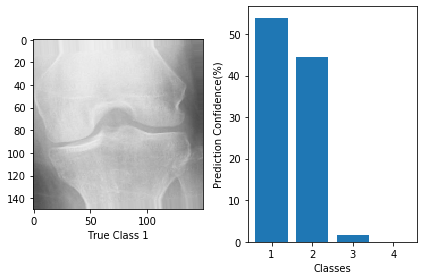

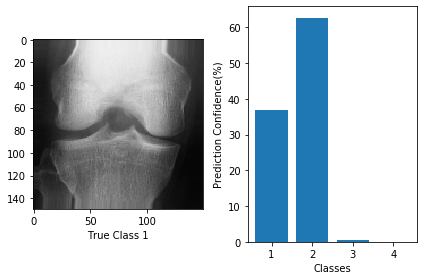

In [64]:
#Gives % confidence predictions and shows on bar chart.

x, y = test_data_gen.next()
pred_array = model.predict(x)
y = np.argmax(y, axis=1)

for i in range(BATCH_SIZE):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.imshow(x[i])
    label = "True Class " + str(y[i] + 1)
    ax1.set_xlabel(label)

    ax2.bar(CLASSES, pred_array[i]*100, width=0.8, bottom=None, align='center', data=None)
    ax2.set_ylabel('Prediction Confidence(%)')
    ax2.set_xlabel("Classes")
    
    fig.tight_layout()
    fig.show()